# Causal Effect Inference

We are in the context of an **observational study**: we observe outcomes ($Y$) for available subjects (with many characteristics $X_i$) on the variables of interest ($T$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

**Causal Graphical Model (Causal Bayesian Network)**

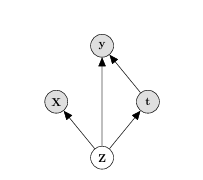

We **observe** the features $X_i$, the treatment $T$ and the outcome $Y$, but we do **not observe** the hidden confounder $Z$!

Our **objective** is to estimate the **Average Treatment Effect** (ATE), i.e., the effect of $T$ on $Y$.

## Causal Theory

The term association refers to statistical dependence. Causality is a special kind of association, so causality implies association but not viceversa. 

Let $T$ be the random variable for the treatment, $Y$ the r.v. for the oucome of nterest and X to denote covariates. Assume for example a binary treatment, *i.e.*, $t\in{0,1}$ where $t$ is the realization of $T$.
The **potential outcome** $Y(t)$ denotes what the outcome would be after the treatment $T=t$, i.e., all the possible outcomes after each possible treatment.

In general we consider many individuals in the population of size $n$. We define the **Individual Treatment Effect** (ITE) as:

$$
\tau_i=Y_i(1)-Y_i(0)
$$

The *fundamental problem of causal inference* is that we cannot observe both $Y_i(0)$ and $Y_i(1)$ for the same individual and so neither the ITE. The idea is to use the **Average Treatment Effect** (ATE):

$$
\text{ATE} = \mathbb{E}[Y(1)-Y(0)]
$$

In [ ]:
from data_gen import synthetic_dataset_non_linear, synthetic_dataset_linear
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from pyro.contrib.cevae import CEVAE
import torch
import matplotlib.pyplot as plt
import logging
from utils import LinearModel,PyroLinearProxyModel,run_experiment,abs_ate_error,rel_ate_error,rmse_ite,plot_three_experiment_results,synthetic_dataset_non_linear,synthetic_dataset_linear
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns


logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)

We generated synthetic data in the following way:

- the hidden confounder is one dimensional with distribution
$$
Z \sim \mathcal{N}(0,1)
$$
- the proxies from which we study the confounder
$$
X_j \sim \mathcal{N}(a_j z,\sigma_X^2)\,,\quad a_j \sim \mathcal{U}_{[-10,10]}
$$
- the treatment and the outcome are
$$
T|Z=z \sim \text{Bernoulli}(\sigma(\beta z))
$$
$$
Y|Z=z,T=t \sim \mathcal{N}(z + t, \sigma_Y^2)

In [3]:
data = synthetic_dataset_linear(n=1000, beta=2.0, num_proxies=10, seed=0)
data.keys()
length_x = len(data["x"][1]) 

#clone
data_original = data.copy()

In [4]:
# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)
data.pop("a",None)

data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0.0,-1.868301,-1.125840,1.0,-10.419271,-0.488647,7.174606,-4.648432,-4.576821,7.489878,6.996157,-4.095944,0.897944,9.790544
1,0.0,-0.538290,-1.152360,1.0,-9.362418,2.158251,7.738794,-4.534320,-5.552610,6.954226,5.887638,-5.219080,1.483338,11.746528
2,0.0,-3.903064,-0.250579,1.0,-0.370637,-1.324946,1.612699,-1.358586,-0.889863,2.247172,-0.042243,-2.090028,0.893964,2.806923
3,1.0,1.080067,-0.433879,1.0,-3.855381,-1.410040,0.407186,-0.369522,-2.708030,4.276383,1.373499,-4.581057,0.293072,4.355963
4,0.0,1.667862,0.848710,1.0,8.152638,-0.456173,-5.582678,0.746877,3.758286,-4.447976,-5.754533,4.323848,-1.834779,-8.086730


We can obtain a naive estimate for the ATE by taking the mean of the outcome in the two groups in the dataset (those that received the treatment and those who didn't). We call this estimate "unadgusted" because we are not considering any of the covariates that can affect the treatment effect.

In [5]:
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("Unadjusted ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))

Unadjusted ATE 2.133092


## First strategy: assuming "No hidden confounders"

Assuming that there are no hidden confounders (also called **unconfoundness**) means that we consider the $X_i$ to be the only confounders and thus we consider them to be measured!

There exists a simple graphical test, the *back-door criterion*, that can be applied to the causal diagram in order to test if a subset of variables is sufficient to yield an unbiased estimate of the causal effect P(y|do(T=t)).

**Back-door criterion**:
A set of variables X satisfies the criterion relative to an ordered pair of variables $(T,Y)$ in a directed acyclic graph G if:
- no node in X is a descendant of $T$
- X blocks every path from $T$ to $Y$

In this case the set of variables $X_i$ satisfy the back-door criterion and we can apply classical methods for causal inference.

In [84]:
# model = CausalModel(data_df, treatment="t", outcome="y", common_causes="z")
# this would be the real model since we know how the data was generated
# however, in a real setting, we don't usually have access to the real confounders and we consider the proxies variables we have for it instead  

model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

![](../images/causal_model_no_hidden_confounder.png)

We identify the **estimand** using the back-door criterion. Again, we remark the need for the unconfoundedness assumption.

The estimand type is **non parametric** because we are **not** assuming any parametric model for the treatment effect.

The other two types of estimand (instrumental variable and front-door criterion) are **not** available because there are no instrumental variables or mediators in the causal graph. 


In [85]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_0,x_7,x_5,x_9,x_1,x_2,x_3,x_8,x_6,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_0,x_7,x_5,x_9,x_1,x_2,x_3,x_8,x_6,x_4,U) = P(y|t,x_0,x_7,x_5,x_9,x_1,x_2,x_3,x_8,x_6,x_4)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



We want to compute how the value of $y$ will change with respect to $T$, controlling for all $X_i$.

Since we have obtained a backdoor set we use the **Back-door adjustment**:
If a set of variables X satisfy the back-door criterion relative to (T,Y) then the causal effect of T on Y is identifiable and is given by the formula:
$$p(y|do(t))=\sum_x P(y|t,x)P(x)$$

We can see from this formula that estimating the back-door adjust is thus equivalent to estimate the *conditional probability distribution* $P(y|t,x)$. One of the most common method to do so is to use **linear regression**. 

The linear regression method is useful when the data-generating process for the outcome Y can be approximated as the linear function $Y = \beta_0 + \beta_1 T + \beta_2 X + \varepsilon$. When we fit the linear model we are estimating $\mathbb{\hat E}[Y|T=t,X=x]$.

We then compute the causal effect by marginalizing over all values of x and we use as estimate of the probability of each value $\hat P(x)$ the frequency of that value in the dataset. We obtain:
$$\hat p(y|do(t)) \approx \sum_x \mathbb{\hat E}[Y|T=t,X=x]\hat P(x)$$

In [86]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_0,x_7,x_5,x_9,x_1,x_2,x_3,x_8,x_6,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_0,x_7,x_5,x_9,x_1,x_2,x_3,x_8,x_6,x_4,U) = P(y|t,x_0,x_7,x_5,x_9,x_1,x_2,x_3,x_8,x_6,x_4)

## Realized estimand
b: y~t+x_0+x_7+x_5+x_9+x_1+x_2+x_3+x_8+x_6+x_4
Target units: ate

## Estimate
Mean value: 1.1774522111890628
p-value: [6.5828959e-86]



We can also explicitely compute the linear regression using scikit-learn: we verify that the result is the same!

In [87]:
feature_cols = [f'x_{i}' for i in range(10)]
x = data_df[feature_cols]   
t = np.asarray(data_df['t'])
y = data_df['y']

linear_model = LinearModel()
linear_model.fit(x, t, y)          

ite = linear_model.ite(x)         
ate = ite.mean().item()
print("Average Treatment Effect (ATE):", ate)


Average Treatment Effect (ATE): 1.1774518489837646


We estimated that receiving the treatment (t=1) increases the outcome of $1.291$ units after adjusting for covariates. This estimates has a very small p-value, suggesting that this effect is statistically significant.

**Remark**: We also verified that, if I give to the model the real hidden confounder (Z), it correctly predicts a causal effect close to 1 for all estimation methods!

## Second strategy: keeping into account the latent variable

### PGM

Assume a simple graphical model, as the one defined by the problem. We assume the following general relationship

$$
Z\sim \mathcal{N}(0,1)\\
X\sim \mathcal{N}(az+b,\Sigma_X)\\
T|Z\sim \text{Bernoulli}(\sigma(cz))\\
Y|Z,T\sim\mathcal{N}(et+fz,\sigma_Y)
$$

we want to find all these parameters usign variational inference

In [ ]:
x, t, y, z, ite   = (
    data_original["x"],
    data_original["t"],
    data_original["y"],
    data_original["z"],
    data_original["ite"]
    )

x_train, x_test, t_train, t_test, y_train, y_test, z_train, z_test, ite_train, ite_test = train_test_split(
    x, t, y, z, ite, test_size=0.2, random_state=0
)

In [99]:
pgm = PyroLinearProxyModel(init_scale=0.1, learning_rate=5e-3, weight_decay=0.0)

losses = pgm.fit(x_train, t_train, y_train, num_epochs=1000, log_every=100, posterior_epochs=1000)          


[SVI] epoch  100 ELBO = 16217.29
[SVI] epoch  200 ELBO = 14642.17
[SVI] epoch  300 ELBO = 14124.70
[SVI] epoch  400 ELBO = 13980.87
[SVI] epoch  500 ELBO = 13933.64
[SVI] epoch  600 ELBO = 13915.53
[SVI] epoch  700 ELBO = 13909.74
[SVI] epoch  800 ELBO = 13905.10
[SVI] epoch  900 ELBO = 13904.45
[SVI] epoch 1000 ELBO = 13906.05
[SVI-xt] epoch  101 ELBO = 15243.08
[SVI-xt] epoch  201 ELBO = 13833.77
[SVI-xt] epoch  301 ELBO = 13231.60
[SVI-xt] epoch  401 ELBO = 12940.19
[SVI-xt] epoch  501 ELBO = 12824.80
[SVI-xt] epoch  601 ELBO = 12758.62
[SVI-xt] epoch  701 ELBO = 12734.66
[SVI-xt] epoch  801 ELBO = 12706.25
[SVI-xt] epoch  901 ELBO = 12700.47


In [100]:
ite = pgm.ite_train(x_train)         
ate = ite.mean().item()
# Compute mean squared error between true ITE and computed ITE
true_ite = ite_train
mse = torch.mean((ite.flatten() - true_ite.flatten()) ** 2).item()

print("Results for training data")
print("Average Treatment Effect (ATE) (through ITE)", ate)
print("Estimated ATE fro model coefficients (by def):", pgm.estimate_ate())
print("Mean Squared Error between true ITE and computed ITE:", mse)
# print(ite)

Results for training data
Average Treatment Effect (ATE) (through ITE) 0.9781777858734131
Estimated ATE fro model coefficients (by def): 0.9779980778694153
Mean Squared Error between true ITE and computed ITE: 0.002160669770091772


here for each $z_i$ there is a pair $(\mu_i,\sigma_i)$, so if we want to predict $z$ for unseen values of $x$ we must train again the model on the new data points.

In [101]:
loc   = pyro.param("AutoDiagonalNormal.loc")   # shape [N]
scale = pyro.param("AutoDiagonalNormal.scale") # shape [N]

# Example: pick out the first few
for i in range(10):
    print(f"z_{i} ~ Normal(mean={loc[i].item():.2f}, std={scale[i].item():.2f})")

z_0 ~ Normal(mean=0.23, std=0.26)
z_1 ~ Normal(mean=-0.21, std=0.28)
z_2 ~ Normal(mean=-0.47, std=0.26)
z_3 ~ Normal(mean=-1.64, std=0.27)
z_4 ~ Normal(mean=-1.60, std=0.29)
z_5 ~ Normal(mean=2.14, std=0.28)
z_6 ~ Normal(mean=-1.50, std=0.30)
z_7 ~ Normal(mean=-0.15, std=0.29)
z_8 ~ Normal(mean=1.23, std=0.29)
z_9 ~ Normal(mean=-0.32, std=0.28)


trying to predict on the test set; this requires local refit (doable only for small test samples and for theory sake)

In [102]:
ite_pred = pgm.ite(x_test)
true_ite = ite_test
mse = torch.mean((ite_pred.flatten() - true_ite.flatten()) ** 2).item()

print("Predicted ITEs:", ite_pred)
print("Mean Squared Error between predicted ITE and true ITE:", mse)
ate_pred = pgm.estimate_ate()
print("Predicted ATE (through ITE)", ite_pred.mean(0).item())
print("Predicted ATE (with params):", ate_pred)


Predicted ITEs: tensor([ 0.8167,  0.9772,  0.5554,  1.5210,  0.7720,  1.0404,  1.1538,  0.7676,
         1.0703,  0.6947,  0.7318,  0.9985,  0.8402,  1.0185,  1.6213,  1.0514,
         0.9732,  0.5505,  0.7991,  0.4393,  0.5212,  0.9271,  0.9005,  0.4495,
         1.2953,  1.0334,  0.8259,  1.3378,  1.4606,  1.7261,  1.2750,  1.4001,
         1.3216,  0.9774,  1.2568,  0.5599,  0.4292,  0.4952,  0.5896,  1.0300,
         0.8854,  1.8197,  0.6400,  1.1110,  0.9933,  1.1646,  0.8616,  0.8839,
         1.4486,  0.0847,  1.1301,  1.3074,  1.1582,  1.4390,  1.6107,  0.7083,
         1.1741,  1.1953,  0.5921,  1.2246,  0.6036,  0.8122,  1.3026,  1.1640,
         0.5952,  0.6247,  1.2416,  0.6048,  1.3409,  1.4591,  0.4205,  1.3802,
        -0.1882,  1.2469,  0.4236,  0.6783,  1.1426,  1.2096,  0.5436,  1.1281,
         1.1251,  0.7980,  0.9405,  0.5346,  0.1317,  0.0693,  0.9166,  0.6600,
         1.0549,  1.0449,  0.9302,  1.5528,  0.9660,  0.8711,  1.2020,  1.3591,
         1.3947,  0.3250

### CEVAE

If we think that there must be an hidden confounder that we have to account for, we can use the Causal Effect Variational AutoEncoder (CEVAE) to try to estimate it based on the available data.

CEVAE is composed by two networks that work together in an encoder-decoder way:

### 1. Inference Network (Encoder)

This network learns to **infer hidder confounder Z** from the observed data. 

Inputs:

- Features **X**
- Treatment **t**
- Outcome **y**

Output:

A probability distribution over **Z** (in this case a Gaussian with learned mean and variance). 

**Key idea:** by observing **X,t,y** the architecture can work in a backward way to reconstruct how **Z** looked like.

In this network, $q(z|t,y,x)$ is computed.

![Encoder](../images/inference_network_cevae.png)

### 2. Model Network (Decoder)

This network represents our **causal understanding** of how the variables relate. It models:

- $p(x|z)$ : how proxies depend on hidden confounders
- $p(t|z)$ : how treatment assignment depends on confounders
- $p(y|t,z)$ : how outcomes depend on treatment and confounders

![Decoder](../images/model_network_cevae.png)

## Training Phase

The core training objective is to maximize the ELBO:

$L = \sum_{i=1}^{N} \mathbb{E}_{q(z_i|x_i,t_i,y_i)}[\log p(x_i,t_i|z_i) + \log p(y_i|t_i,z_i) + \underbrace{\log p(z_i) - \log q(z_i|x_i,t_i,y_i)}_{-KL[q(Z|X,t,y)||p(Z)]}]$

This balances:

- How well we reconstruct **y** given our inferred **Z**
- How plausible our inferred **Z** values are
- The complexity of our inference network

Also, auxiliary networks are used for prediction. Since during training we know **t** and **y**, but not for new patients, two networks are trained:

- $q(t|X)$ : which predicts treatment from proxies alone
- $q(y|X,t)$ : which predicts outcomes from proxies and treatment

Thus the loss function to minimize becomes:
$\mathcal{F}_{CEVAE} = \underbrace{L}_{\text{ELBO}} + \sum_{i=1}^N (\underbrace{\log q(t_i=t_i^*|x_i^*)}_{\text{Treatment Pred. Loss}} + \underbrace{\log q(y_i=y_i^*|x_i^*,t_i^*)}_{\text{Outcome Pred. Loss}})$

During training the parameters are optimized using backpropagation.

![CEVAE Architecture](../images/cevae_architecture.jpeg)

## Prediction Phase

For a new patient instead:

1. We need to integrate over unknown **t** and **y**:
   $q(z|x) = \sum_t \int_y q(z|x,t,y) q(y|x,t) q(t|x) \,dy$

2. We sample several **z** values from this distribution

3. For each **z**, we use the MODEL network to predict:
   - Outcome if treated: $p(y|t=1, z)$
   - Outcome if not treated: $p(y|t=0, z)$

4. The difference gives us the individual treatment effect

In [6]:
x, t, y   = (
    data_original["x"],
    data_original["t"],
    data_original["y"]
    )

z = data_original["z"]

length_x  = x.shape[1]

# ----------------------------- train-test split ----------------------------- #

x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(
    x, t, y, test_size=0.2, random_state=0
)

INFO 	 Training with 8 minibatches per epoch
DEBUG 	 step     0 loss = 26.5995
DEBUG 	 step   100 loss = 8.92462
DEBUG 	 step   200 loss = 7.78166
DEBUG 	 step   300 loss = 7.78937
DEBUG 	 step   400 loss = 7.23809
DEBUG 	 step   500 loss = 6.35593
DEBUG 	 step   600 loss = 6.05054
DEBUG 	 step   700 loss = 6.23666


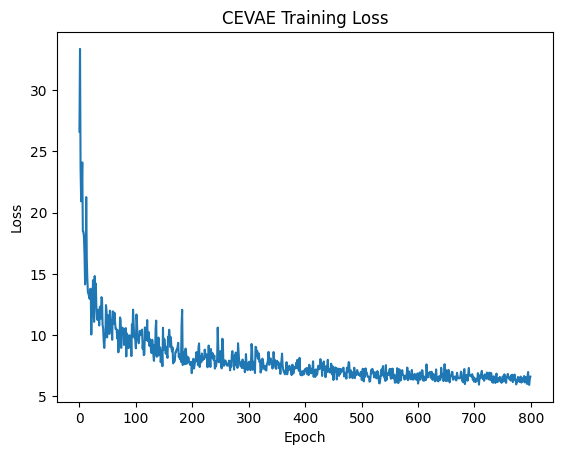

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.914966


Estimated (test) ATE: 0.9150
True ATE: 1.0000


In [7]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

losses = cevae.fit(
    x_train, t_train, y_train,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

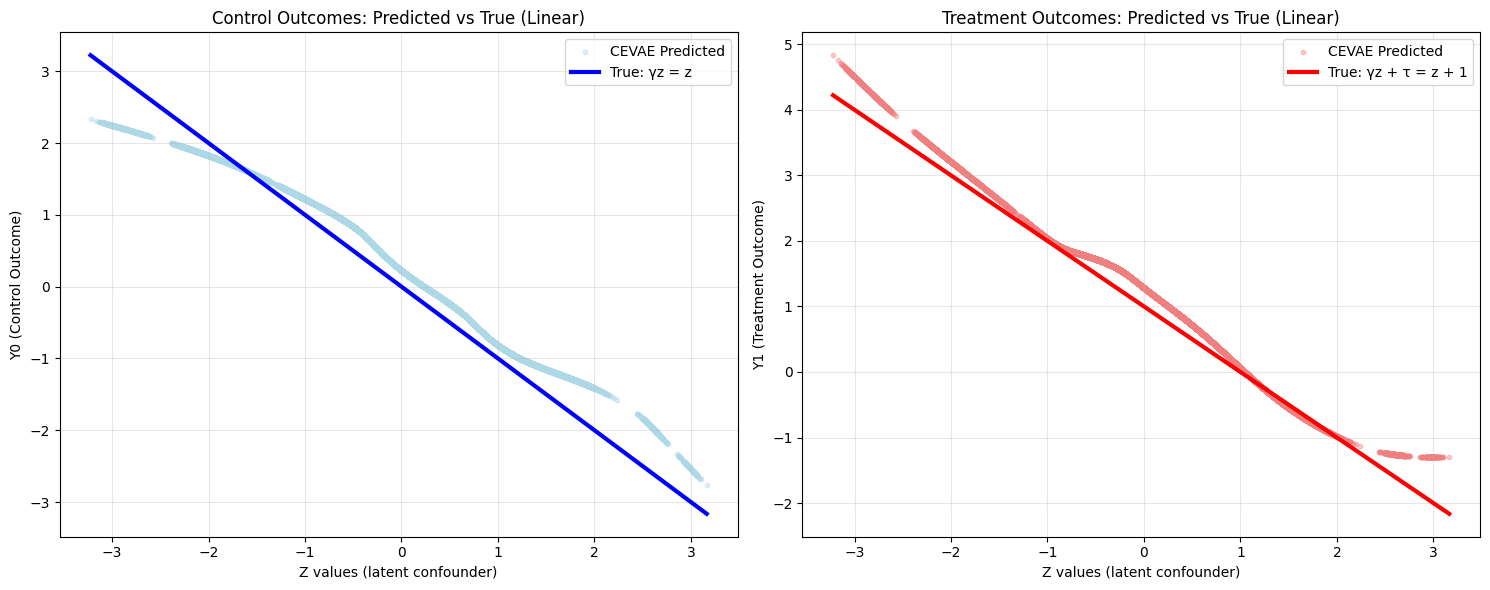

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pyro import poutine

@torch.no_grad()
def plot_predicted_vs_true(cevae, x_test, num_samples=100):
    """
    Plot predicted outcomes vs true functions - linear case
    """
    # Get z values and predicted outcomes
    x = cevae.whiten(x_test)
    
    with pyro.plate("num_particles", num_samples, dim=-2):
        with poutine.trace() as tr, poutine.block(hide=["y", "t"]):
            cevae.guide(x)
        
        z = tr.trace.nodes["z"]["value"]  # [num_samples, batch_size, latent_dim]
        
        with poutine.do(data=dict(t=torch.zeros(()))):
            y0_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
        
        with poutine.do(data=dict(t=torch.ones(()))):
            y1_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
    
    # Flatten for plotting
    z_flat = z.reshape(-1, z.shape[-1])
    y0_pred_flat = y0_pred.reshape(-1)
    y1_pred_flat = y1_pred.reshape(-1)
    
    # Use first dimension of z if multi-dimensional
    z_plot = z_flat[:, 0] if z_flat.shape[1] > 0 else z_flat
    
    # Sort by z values
    sorted_indices = torch.argsort(z_plot)
    z_sorted = z_plot[sorted_indices]
    y0_pred_sorted = y0_pred_flat[sorted_indices]
    y1_pred_sorted = y1_pred_flat[sorted_indices]
    
    # Calculate true functions for LINEAR case
    gamma_true = -1.0 # IMPORTANT: This can be modified based on change-of-sign problem {+1,-1}
    tau_true = 1.0 
    y0_true = gamma_true * z_sorted                    # Y0 = gamma * z = z
    y1_true = gamma_true * z_sorted + tau_true         # Y1 = gamma * z + tau = z + 1
    tau_true_constant = torch.full_like(z_sorted, tau_true)  # Constant ITE = 1
    
    return z_sorted, y0_pred_sorted, y1_pred_sorted, y0_true, y1_true, tau_true_constant

# Get the data
z_sorted, y0_pred, y1_pred, y0_true, y1_true, tau_true = plot_predicted_vs_true(cevae, x_test)

# Create the plots - only first horizontal line
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Y0 (Control outcomes)
axes[0].scatter(z_sorted.cpu(), y0_pred.cpu(), alpha=0.4, s=10, color='lightblue', label='CEVAE Predicted')
axes[0].plot(z_sorted.cpu(), y0_true.cpu(), 'b-', linewidth=3, label='True: γz = z')  # Updated label
axes[0].set_xlabel('Z values (latent confounder)')
axes[0].set_ylabel('Y0 (Control Outcome)')
axes[0].set_title('Control Outcomes: Predicted vs True (Linear)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Y1 (Treatment outcomes)
axes[1].scatter(z_sorted.cpu(), y1_pred.cpu(), alpha=0.4, s=10, color='lightcoral', label='CEVAE Predicted')
axes[1].plot(z_sorted.cpu(), y1_true.cpu(), 'r-', linewidth=3, label='True: γz + τ = z + 1')  # Updated label
axes[1].set_xlabel('Z values (latent confounder)')
axes[1].set_ylabel('Y1 (Treatment Outcome)')
axes[1].set_title('Treatment Outcomes: Predicted vs True (Linear)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save the model
#torch.save(cevae, "cevae_model_full.pth")

#cevae_loaded = torch.load("cevae_model_full.pth", weights_only=False)

#### Using non-linear data

INFO 	 Training with 16 minibatches per epoch
DEBUG 	 step     0 loss = 27.3256
DEBUG 	 step   100 loss = 19.0669
DEBUG 	 step   200 loss = 18.5266
DEBUG 	 step   300 loss = 18.376
DEBUG 	 step   400 loss = 18.6427
DEBUG 	 step   500 loss = 18.5126
DEBUG 	 step   600 loss = 18.5792
DEBUG 	 step   700 loss = 18.6648
DEBUG 	 step   800 loss = 18.679
DEBUG 	 step   900 loss = 18.5933
DEBUG 	 step  1000 loss = 18.1547
DEBUG 	 step  1100 loss = 18.5514
DEBUG 	 step  1200 loss = 18.9734
DEBUG 	 step  1300 loss = 18.6053
DEBUG 	 step  1400 loss = 18.3477
DEBUG 	 step  1500 loss = 18.3672


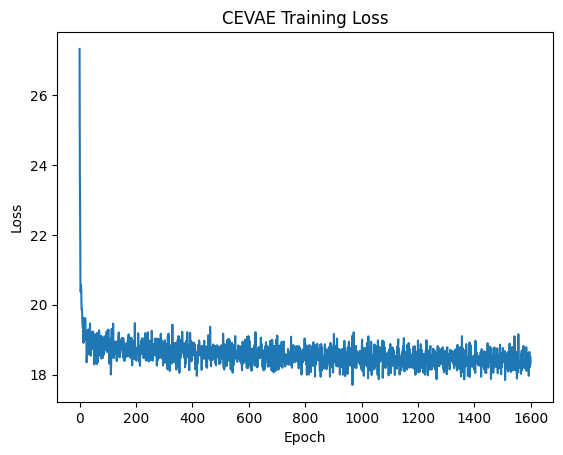

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.42208


Estimated (test) ATE: 1.4221
True ATE: 1.0008


In [9]:
data_non_linear = synthetic_dataset_non_linear(n=2000, beta=2.0, num_proxies=10, prior_type='gaussian', seed=42)
data_non_linear.keys()

x, t, y   = (
    data_non_linear["x"],
    data_non_linear["t"],
    data_non_linear["y"]
    )

z = data_non_linear["z"]

length_x  = x.shape[1]

# ----------------------------- train-test split ----------------------------- #

x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(
    x, t, y, test_size=0.2, random_state=0
)

# before every training run:
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=5,
    hidden_dim=300
    )

losses = cevae.fit(
    x_train, t_train, y_train,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-4,
    learning_rate_decay=0.1,
    weight_decay=1e-6
    )

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite_non_linear = cevae.ite(x_test)
ate_non_linear = ite_non_linear.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate_non_linear:.4f}")
print(f"True ATE: {data_non_linear['ite'].mean().item():.4f}")

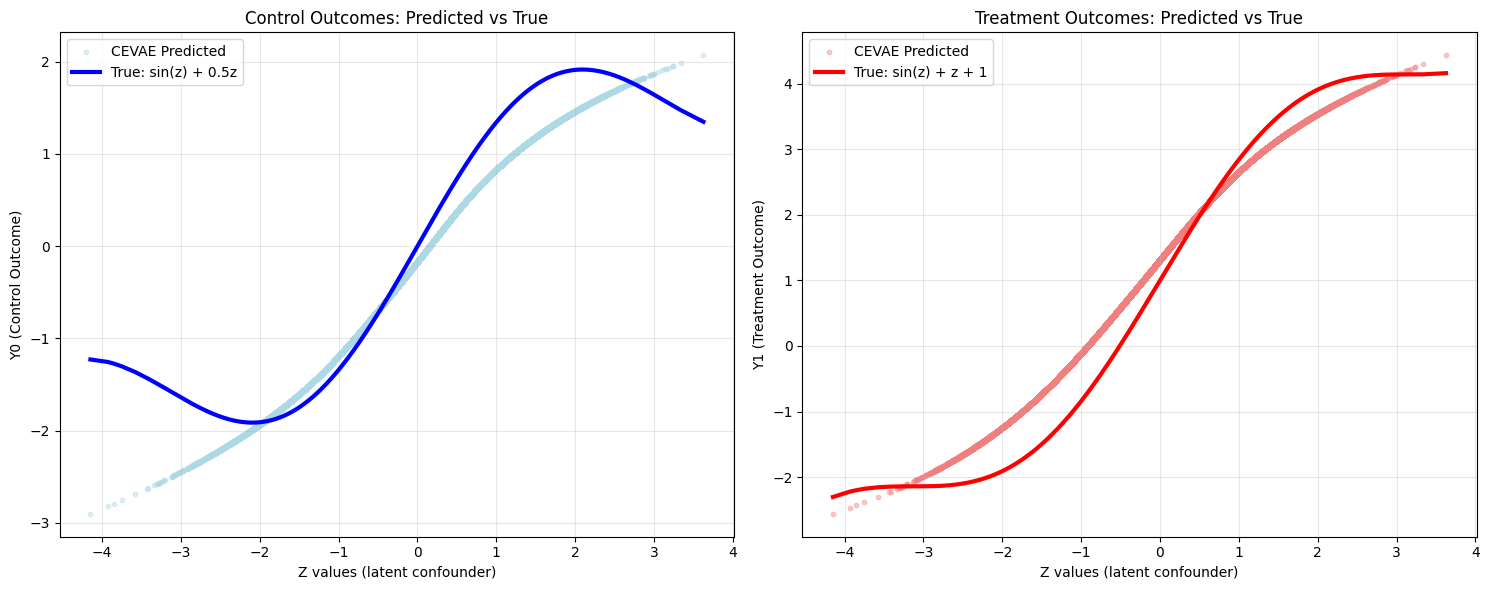

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pyro import poutine

@torch.no_grad()
def plot_predicted_vs_true(cevae, x_test, num_samples=100):
    """
    Plot predicted outcomes vs true functions - first row only
    """
    # Get z values and predicted outcomes
    x = cevae.whiten(x_test)
    
    with pyro.plate("num_particles", num_samples, dim=-2):
        with poutine.trace() as tr, poutine.block(hide=["y", "t"]):
            cevae.guide(x)
        
        z = tr.trace.nodes["z"]["value"]  # [num_samples, batch_size, latent_dim]
        
        with poutine.do(data=dict(t=torch.zeros(()))):
            y0_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
        
        with poutine.do(data=dict(t=torch.ones(()))):
            y1_pred = poutine.replay(cevae.model.y_mean, tr.trace)(x)
    
    # Flatten for plotting
    z_flat = z.reshape(-1, z.shape[-1])
    y0_pred_flat = y0_pred.reshape(-1)
    y1_pred_flat = y1_pred.reshape(-1)
    
    # Use first dimension of z if multi-dimensional
    z_plot = z_flat[:, 0] if z_flat.shape[1] > 0 else z_flat
    
    # Sort by z values
    sorted_indices = torch.argsort(z_plot)
    z_sorted = z_plot[sorted_indices]
    y0_pred_sorted = y0_pred_flat[sorted_indices]
    y1_pred_sorted = y1_pred_flat[sorted_indices]
    
    # Calculate true functions
    g_true = torch.sin(z_sorted) + 0.5 * z_sorted  # Control outcome
    tau_true = 1.0 + 0.5 * z_sorted  # Treatment effect
    y1_true = g_true + tau_true  # Treatment outcome
    
    return z_sorted, y0_pred_sorted, y1_pred_sorted, g_true, y1_true, tau_true

# Get the data
z_sorted, y0_pred, y1_pred, y0_true, y1_true, tau_true = plot_predicted_vs_true(cevae, x_test)

# Create the plots - only first horizontal line
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Y0 (Control outcomes)
axes[0].scatter(z_sorted.cpu(), y0_pred.cpu(), alpha=0.4, s=10, color='lightblue', label='CEVAE Predicted')
axes[0].plot(z_sorted.cpu(), y0_true.cpu(), 'b-', linewidth=3, label='True: sin(z) + 0.5z')
axes[0].set_xlabel('Z values (latent confounder)')
axes[0].set_ylabel('Y0 (Control Outcome)')
axes[0].set_title('Control Outcomes: Predicted vs True')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Y1 (Treatment outcomes)
axes[1].scatter(z_sorted.cpu(), y1_pred.cpu(), alpha=0.4, s=10, color='lightcoral', label='CEVAE Predicted')
axes[1].plot(z_sorted.cpu(), y1_true.cpu(), 'r-', linewidth=3, label='True: sin(z) + z + 1')
axes[1].set_xlabel('Z values (latent confounder)')
axes[1].set_ylabel('Y1 (Treatment Outcome)')
axes[1].set_title('Treatment Outcomes: Predicted vs True')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Experiments

### Plot also the test loss

In [11]:
import torch, types
from torch.utils.data import DataLoader, TensorDataset
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.optim import ClippedAdam
from pyro.contrib.cevae import PreWhitener, TraceCausalEffect_ELBO

def train_cevae(
    model,                      # a CEVAE instance
    x, t, y,                    # training data
    x_val=None, t_val=None, y_val=None,   # optional validation data
    num_epochs=100, batch_size=100,
    lr=1e-3, lr_decay=0.1, weight_decay=1e-4,
    log_every=10,
):
    model.whiten = PreWhitener(x)           # <-- same pre-whiten stats
    train_loader = DataLoader(TensorDataset(x, t, y),
                              batch_size=batch_size, shuffle=True,
                              generator=torch.Generator(device=x.device))
    num_steps = num_epochs * len(train_loader)
    optim = ClippedAdam({"lr": lr,
                         "weight_decay": weight_decay,
                         "lrd": lr_decay ** (1/num_steps)})
    svi = SVI(model.model, model.guide, optim, TraceCausalEffect_ELBO())
    tr_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # ---- training pass
        epoch_loss = 0.0
        for xb, tb, yb in train_loader:
            xb = model.whiten(xb)
            batch_loss = svi.step(xb, tb, yb, size=len(x))
            batch_loss = batch_loss / len(x)
            epoch_loss += batch_loss

        tr_losses.append(epoch_loss / len(train_loader))

        # ---- validation pass (optional)
        if x_val is not None:
            with torch.no_grad():
                xv = model.whiten(x_val)
                vloss = svi.evaluate_loss(xv, t_val, y_val,
                                          size=len(x_val)) / len(x_val)
            val_losses.append(vloss)

        if log_every and (epoch+1) % log_every == 0:
            msg = f"[{epoch+1:03d}] train={tr_losses[-1]:.4f}"
            if x_val is not None:
                msg += f" | val={val_losses[-1]:.4f}"
            print(msg)

    return (tr_losses, val_losses) if x_val is not None else tr_losses


In [12]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

train_losses, val_losses = train_cevae(
    cevae,
    x_train, t_train, y_train,
    x_val=x_test, t_val=t_test, y_val=y_test,
    num_epochs=100,
    batch_size=100,
    lr=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )


[010] train=18.9710 | val=18.9954
[020] train=18.8524 | val=19.1478
[030] train=18.7327 | val=18.9980
[040] train=18.6274 | val=19.1449
[050] train=18.5447 | val=19.5807
[060] train=18.4437 | val=20.1331
[070] train=18.3619 | val=20.3530
[080] train=18.2860 | val=21.4999
[090] train=18.2515 | val=23.3715
[100] train=18.2095 | val=25.6464


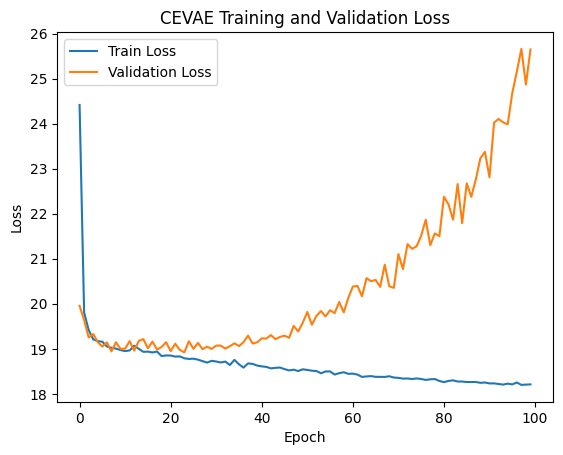

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.57743


Estimated (test) ATE: 1.5774
True ATE: 1.0000


In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training and Validation Loss')
plt.legend()
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

### Setting parameters defaults

In [14]:
num_proxies = 10
n_data = 200

data_defaults_non_lin = dict(
    n=n_data,
    num_proxies=num_proxies,
    sigma_x=1.0,
    sigma_y=1.0,
    prior_type="gaussian",
    seed=0,
)

data_defaults_linear = dict(
    n=n_data,
    beta=1.0,
    num_proxies=num_proxies,
    shuffle_pct=0.0,
    sigma_x=1.0,
    sigma_y=1.0,
    seed=0,
)

model_defaults = dict(
    feature_dim=num_proxies,
    latent_dim=1,
    num_layers=3,   # number of hidden layers
    hidden_dim=200,  # number of hidden units in each layer
    outcome_dist="normal",
)

fit_defaults = dict(
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=0,
)

pgm_fit_defaults = dict(
    num_epochs=1000,
    posterior_epochs=1000,
    batch_size=100,  # ignored here, we do full-batch
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=100,
)

metrics = {
    "abs_ate_err": rel_ate_error,
    "rmse_ite": rmse_ite,
}

# fixing the experiment data generating function


#### Choosing the dataset

In [15]:

dataset_type = "non_linear"  # or "non_linear"

if dataset_type == "non_linear":
    data_gen_fn = synthetic_dataset_non_linear
    data_defaults = data_defaults_non_lin
elif dataset_type == "linear":
    data_gen_fn = synthetic_dataset_linear
    data_defaults = data_defaults_linear


### E1: increasing sample size

In [28]:
# set up params to sweep
param_grid = {
    "data__n": np.linspace(100,1000,10, dtype=int),
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 1435.05
[SVI] epoch  200 ELBO = 1339.33
[SVI] epoch  300 ELBO = 1320.94
[SVI] epoch  400 ELBO = 1314.86
[SVI] epoch  500 ELBO = 1311.70
[SVI] epoch  600 ELBO = 1313.20
[SVI] epoch  700 ELBO = 1312.32
[SVI] epoch  800 ELBO = 1310.11
[SVI] epoch  900 ELBO = 1310.68
[SVI] epoch 1000 ELBO = 1309.23
[SVI-xt] epoch  101 ELBO = 1243.17
[SVI-xt] epoch  201 ELBO = 1189.59
[SVI-xt] epoch  301 ELBO = 1176.04
[SVI-xt] epoch  401 ELBO = 1179.18
[SVI-xt] epoch  501 ELBO = 1176.88
[SVI-xt] epoch  601 ELBO = 1178.78
[SVI-xt] epoch  701 ELBO = 1178.38
[SVI-xt] epoch  801 ELBO = 1176.99
[SVI-xt] epoch  901 ELBO = 1176.65
[SVI] epoch  100 ELBO = 3134.42
[SVI] epoch  200 ELBO = 2797.06
[SVI] epoch  300 ELBO = 2757.86
[SVI] epoch  400 ELBO = 2752.14
[SVI] epoch  500 ELBO = 2748.45
[SVI] epoch  600 ELBO = 2745.01
[SVI] epoch  700 ELBO = 2745.47
[SVI] epoch  800 ELBO = 2738.95
[SVI] epoch  900 ELBO = 2743.17
[SVI] epoch 1000 ELBO = 2744.03
[SVI-xt] epoch  101 ELBO = 2600.02
[SVI-xt] e

INFO 	 Training with 1 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.50624
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.56825
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76169
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78197
INFO 	 Training with 3 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.58882
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.57182
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.34381
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.3553
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.31191
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33475
INFO 	 Training with 5 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.48095
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.48473
INFO 	 Trai

In [27]:
def plot_three_experiment_results(ceave_res, linear, pgm, x_param="data__shuffle_pct", palette_name="Set2"):
    """
    Plot results and linear_results overlapping for each metric on the same plot,
    using a nicer seaborn color palette.
    """
    # set up seaborn styling
    sns.set_style("whitegrid")
    sns.set_context("talk")  # makes labels/text a bit larger

    # find all metric columns
    metrics = [c for c in ceave_res.columns if c not in (x_param, "final_elbo")]

    # grab exactly 3 colors from the specified palette
    colors = sns.color_palette(palette_name, n_colors=3)

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(ceave_res[x_param], ceave_res[metric],
                 marker="o", label="CEVAE", color=colors[0])
        plt.plot(linear[x_param], linear[metric],
                 marker="x", label="Linear Regression", color=colors[1])
        plt.plot(pgm[x_param], pgm[metric],
                 marker="^", label="PGM", color=colors[2])

        plt.xlabel(x_param, fontsize=12)
        plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}", fontsize=14)
        plt.legend(frameon=True)
        plt.tight_layout()
        plt.show()

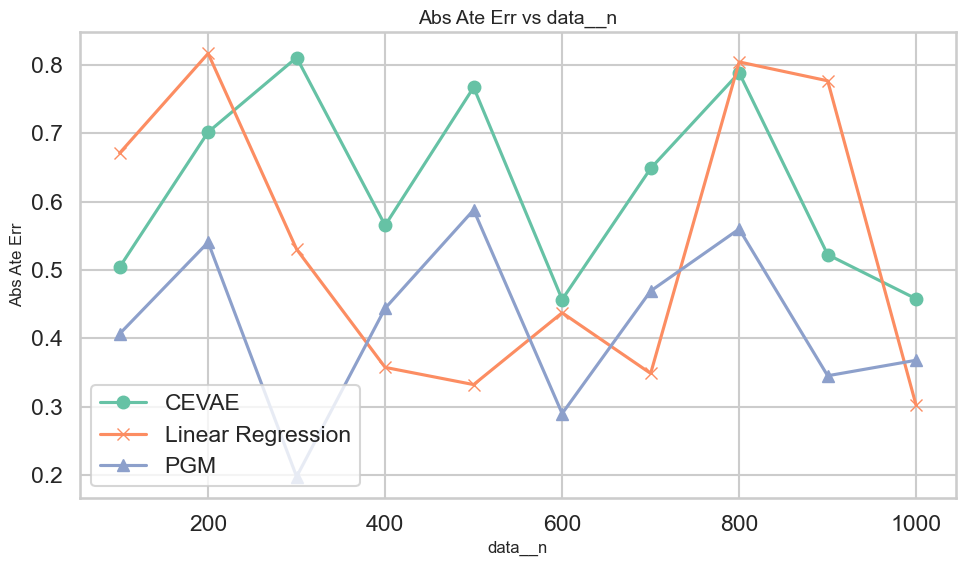

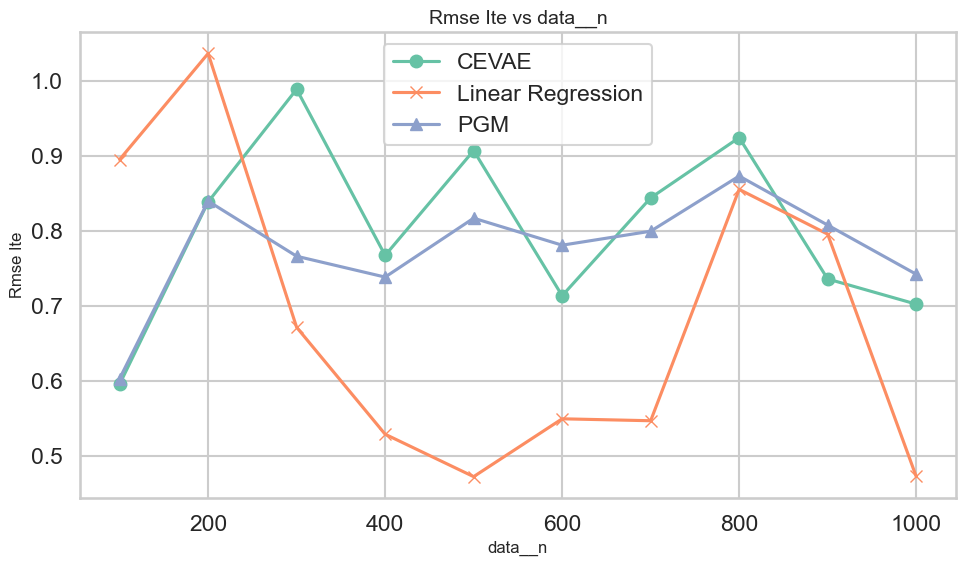

In [29]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__n")

### E2: increasing correlation among proxies (not through $Z$)

In [20]:
# set up params to sweep
param_grid = {
    "data__rho": np.linspace(0.0, 0.9, 10),
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 3134.42
[SVI] epoch  200 ELBO = 2797.06
[SVI] epoch  300 ELBO = 2757.86
[SVI] epoch  400 ELBO = 2752.14
[SVI] epoch  500 ELBO = 2748.45
[SVI] epoch  600 ELBO = 2745.01
[SVI] epoch  700 ELBO = 2745.47
[SVI] epoch  800 ELBO = 2738.95
[SVI] epoch  900 ELBO = 2743.17
[SVI] epoch 1000 ELBO = 2744.03
[SVI-xt] epoch  101 ELBO = 2600.02
[SVI-xt] epoch  201 ELBO = 2495.26
[SVI-xt] epoch  301 ELBO = 2484.41
[SVI-xt] epoch  401 ELBO = 2485.26
[SVI-xt] epoch  501 ELBO = 2485.51
[SVI-xt] epoch  601 ELBO = 2482.30
[SVI-xt] epoch  701 ELBO = 2486.92
[SVI-xt] epoch  801 ELBO = 2486.59
[SVI-xt] epoch  901 ELBO = 2484.31
[SVI] epoch  100 ELBO = 3094.99
[SVI] epoch  200 ELBO = 2796.50
[SVI] epoch  300 ELBO = 2758.73
[SVI] epoch  400 ELBO = 2752.62
[SVI] epoch  500 ELBO = 2748.64
[SVI] epoch  600 ELBO = 2744.70
[SVI] epoch  700 ELBO = 2745.45
[SVI] epoch  800 ELBO = 2739.01
[SVI] epoch  900 ELBO = 2743.29
[SVI] epoch 1000 ELBO = 2744.11
[SVI-xt] epoch  101 ELBO = 2599.21
[SVI-xt] e

INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76169
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78197
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.80173
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.81779
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.81179
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.80086
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.93492
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.92293
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.81506
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.8106
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.9251
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.92939
INFO 	 Train

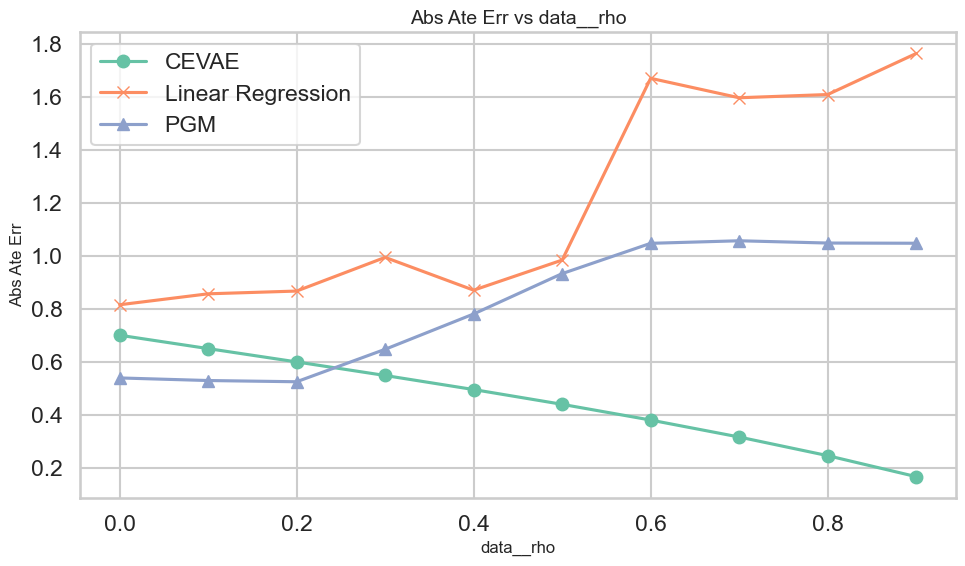

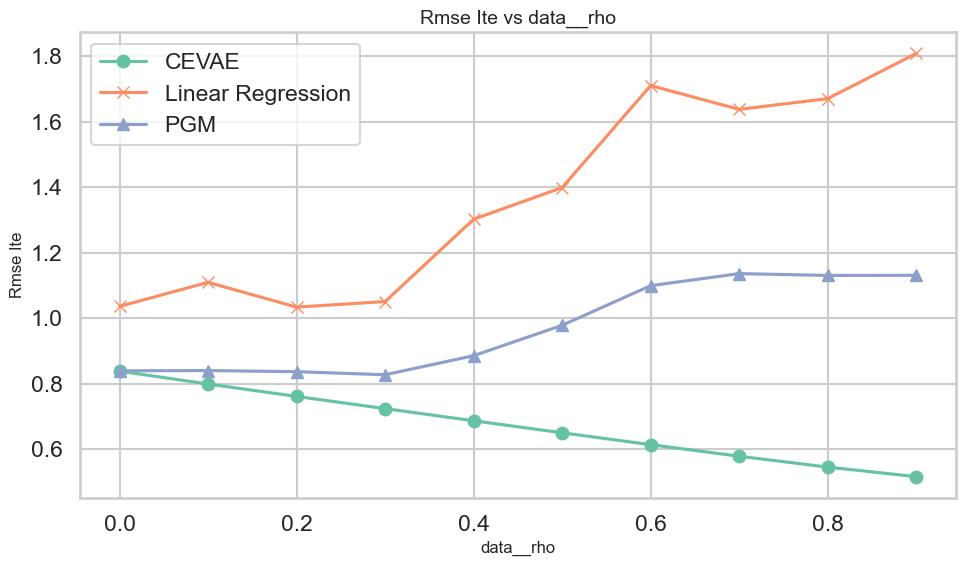

In [26]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__rho")

### E3: increasing decorellation among proxies (through shuffling)

In [23]:
# set up params to sweep
param_grid = {
    "data__shuffle_pct": np.linspace(0.0, 1.0, 11)
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 3134.42
[SVI] epoch  200 ELBO = 2797.06
[SVI] epoch  300 ELBO = 2757.86
[SVI] epoch  400 ELBO = 2752.14
[SVI] epoch  500 ELBO = 2748.45
[SVI] epoch  600 ELBO = 2745.01
[SVI] epoch  700 ELBO = 2745.47
[SVI] epoch  800 ELBO = 2738.95
[SVI] epoch  900 ELBO = 2743.17
[SVI] epoch 1000 ELBO = 2744.03
[SVI-xt] epoch  101 ELBO = 2600.02
[SVI-xt] epoch  201 ELBO = 2495.26
[SVI-xt] epoch  301 ELBO = 2484.41
[SVI-xt] epoch  401 ELBO = 2485.26
[SVI-xt] epoch  501 ELBO = 2485.51
[SVI-xt] epoch  601 ELBO = 2482.30
[SVI-xt] epoch  701 ELBO = 2486.92
[SVI-xt] epoch  801 ELBO = 2486.59
[SVI-xt] epoch  901 ELBO = 2484.31
[SVI] epoch  100 ELBO = 3085.43
[SVI] epoch  200 ELBO = 2823.95
[SVI] epoch  300 ELBO = 2790.07
[SVI] epoch  400 ELBO = 2780.67
[SVI] epoch  500 ELBO = 2781.62
[SVI] epoch  600 ELBO = 2774.52
[SVI] epoch  700 ELBO = 2773.63
[SVI] epoch  800 ELBO = 2776.29
[SVI] epoch  900 ELBO = 2773.81
[SVI] epoch 1000 ELBO = 2772.07
[SVI-xt] epoch  101 ELBO = 2613.60
[SVI-xt] e

INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76169
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78197
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.20736
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.21739
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.23423
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.23404
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.72406
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.74243
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.36855
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.37439
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.51492
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.534
INFO 	 Train

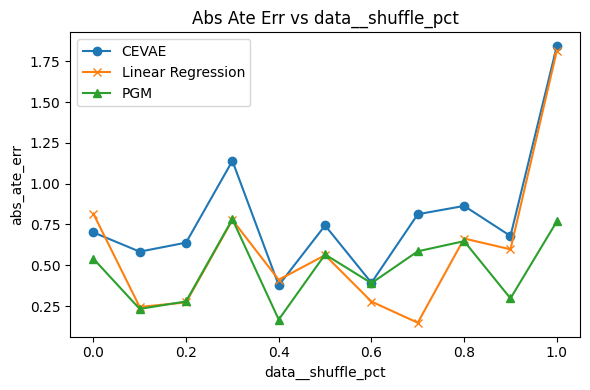

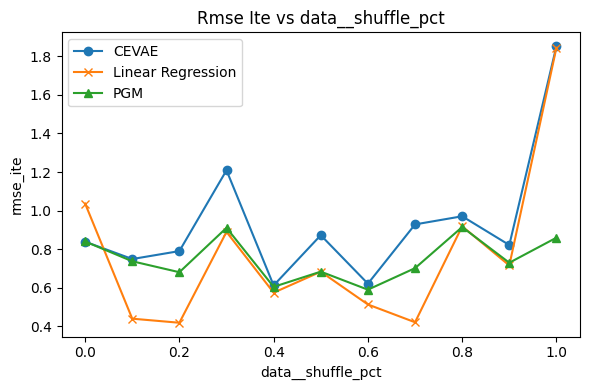

In [24]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__shuffle_pct")

### E4: increasing the latent dimension (of the CEVAE)

In [25]:
# set up params to sweep
param_grid = {
    "model__latent_dim": [1, 2, 5, 10, 20],
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76169
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78197
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.52738
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.51148
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.61026
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.71876
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.52806
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.50367
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.53557
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.57481


### E5: prior misspecification

In [26]:
# set up params to sweep
param_grid = {
    "data__prior_type": ["gaussian", "bimodal"],  # type of prior distribution
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 3134.42
[SVI] epoch  200 ELBO = 2797.06
[SVI] epoch  300 ELBO = 2757.86
[SVI] epoch  400 ELBO = 2752.14
[SVI] epoch  500 ELBO = 2748.45
[SVI] epoch  600 ELBO = 2745.01
[SVI] epoch  700 ELBO = 2745.47
[SVI] epoch  800 ELBO = 2738.95
[SVI] epoch  900 ELBO = 2743.17
[SVI] epoch 1000 ELBO = 2744.03
[SVI-xt] epoch  101 ELBO = 2600.02
[SVI-xt] epoch  201 ELBO = 2495.26
[SVI-xt] epoch  301 ELBO = 2484.41
[SVI-xt] epoch  401 ELBO = 2485.26
[SVI-xt] epoch  501 ELBO = 2485.51
[SVI-xt] epoch  601 ELBO = 2482.30
[SVI-xt] epoch  701 ELBO = 2486.92
[SVI-xt] epoch  801 ELBO = 2486.59
[SVI-xt] epoch  901 ELBO = 2484.31
[SVI] epoch  100 ELBO = 2988.30
[SVI] epoch  200 ELBO = 2787.75
[SVI] epoch  300 ELBO = 2702.86
[SVI] epoch  400 ELBO = 2683.22
[SVI] epoch  500 ELBO = 2665.49
[SVI] epoch  600 ELBO = 2660.40
[SVI] epoch  700 ELBO = 2654.06
[SVI] epoch  800 ELBO = 2649.68
[SVI] epoch  900 ELBO = 2646.65
[SVI] epoch 1000 ELBO = 2643.05
[SVI-xt] epoch  101 ELBO = 2461.96
[SVI-xt] e

INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76169
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78197
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.1499
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.16776


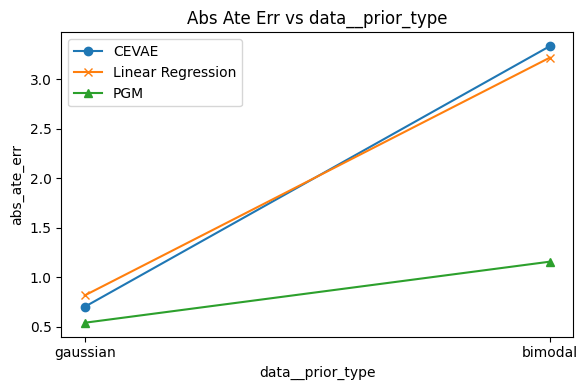

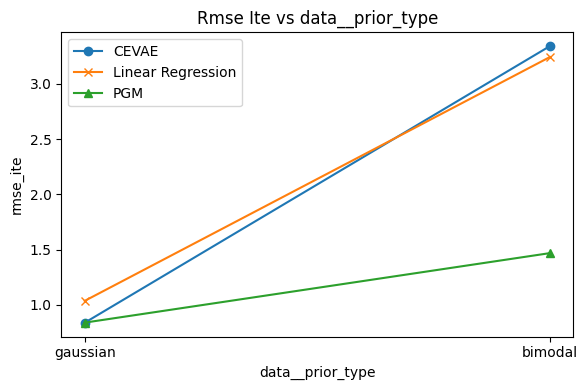

In [27]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__prior_type")